Our dataset is composed of multiple different timeseries, which may not share the same length. As per the [documentation](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb), we will have a list of NumPy arrays of shape (timesteps, features).

In our case, the number of features is simply the amplitude of the signal.

The name of each input is directly coupled with the output filename. 

In [ ]:
import librosa
import os
from constants import GENERATED_INPUT_DIRECTORY, OUTPUT_DIR
from collections import namedtuple
import numpy as np

AudioFile = namedtuple('AudioFile', ['filename', 'waveform'])  # global samplerate : 22050

# Ensure this notebook is run at the root of the project
input_files = os.listdir(GENERATED_INPUT_DIRECTORY)
output_files = os.listdir(OUTPUT_DIR)

# Pre-load file contents
input_files = [AudioFile(in_f, librosa.load(os.path.join(GENERATED_INPUT_DIRECTORY, in_f))[0]) for in_f in input_files]
output_files = [AudioFile(out_f, librosa.load(os.path.join(OUTPUT_DIR, out_f))[0]) for out_f in output_files]

data_input = []
data_output = []

# Format is defined as `file . noise_index . wav`
for out_file in output_files:
    # match output file with its associated inputs
    # (in other words, the original audio file, matched with the ones that have noise added to it)
    associated_inputs: list[AudioFile] = list(filter(lambda af: af.filename.split('.')[0] == out_file.filename.removesuffix('.wav'), input_files))
    for ai in associated_inputs:
        data_input.append(np.array(ai.waveform))
        data_output.append(np.array(out_file.waveform))



print(f"inputs : {data_input} \n \n outputs: {data_output}")

inputs : [array([ 0.00112915,  0.00140381,  0.00134277, ..., -0.00012207,
       -0.00030518, -0.00021362], shape=(4124020,), dtype=float32), array([-0.02819824, -0.13562012, -0.0819397 , ...,  0.04928589,
        0.01907349, -0.00393677], shape=(4124020,), dtype=float32), array([-0.00085449, -0.00088501, -0.0007019 , ..., -0.00021362,
       -0.00030518, -0.00021362], shape=(3216769,), dtype=float32), array([-0.03018188, -0.13790894, -0.08398438, ..., -0.13796997,
       -0.07983398, -0.08624268], shape=(3216769,), dtype=float32), array([-0.00158691, -0.00180054, -0.0010376 , ...,  0.00064087,
        0.00045776,  0.00012207], shape=(3299568,), dtype=float32), array([-0.03091431, -0.13882446, -0.08432007, ..., -0.0793457 ,
       -0.02780151,  0.05270386], shape=(3299568,), dtype=float32), array([ 0.        ,  0.        ,  0.        , ..., -0.00039673,
       -0.00042725, -0.00036621], shape=(3677619,), dtype=float32), array([-0.02932739, -0.13702393, -0.08328247, ..., -0.00579834,
  

We now have the data in the correct shape : for one cell of the `data_input` list at index `i`, we have the ouput to be predicted inside `data_output[i]`.

## Création de l'esn

Importation dépendances nécessair à l'esn

In [5]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass
from reservoirpy import ESN

import numpy as np
import matplotlib.pyplot as plt

Parametres à optimiser

UNITS = 100               # - number of neurons
LEAK_RATE = 0.3           # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 42

rpy.set_seed(SEED)  # make everything reproducible!

Données d entrée

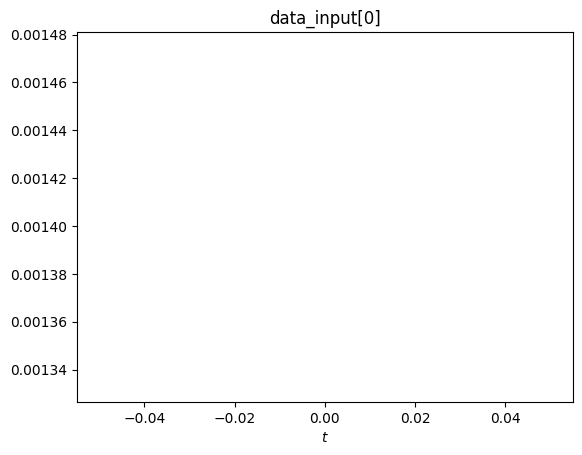

In [ ]:

X_train = data_input[0][:5000].reshape(-1, 1)
Y_train = data_output[0][:5000].reshape(-1, 1)

plt.figure()
plt.plot(X_train, label="Input")
plt.plot(Y_train, label="Output")
plt.xlabel("timestep")
plt.title("5000 premiers échantillons de data_input[0] et data_output[0]")
plt.legend()
plt.show()

création de l'esn

In [21]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = ESN(reservoir, ridge)

Entrainement du modèle

In [22]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)
print(reservoir.initialized, ridge.initialized)


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\reservoirpy\nodes\ridge.py:175: RuntimeWarning: invalid value encountered in divide
  X_means = X_sum / total_samples
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\reservoirpy\nodes\ridge.py:176: RuntimeWarning: invalid value encountered in divide
  Y_means = Y_sum / total_samples


ValueError: array must not contain infs or NaNs